# Polynomial model fit

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as P
import pandas as pd
import glob
import os
import math
import importlib
%matplotlib inline

import amaizeing_utils as maize

## Wrangle the input file

Load the data file

In [5]:
src = '../model/'
data = pd.read_excel(src + '2019GXEleaf_angle.xlsx')
data.head()

,Unnamed: 0,plot,Pass,Range,Rep,New_Pedigree,Old_Pedigree,Old_Source,Shared,LPlant.L1.End.Angle,...,RPlant.L1.End.Angle,RPlant.L1.End.Length,RPlant.L1.Mid.Angle,RPlant.L1.Mid.Length,RPlant.L1.Stem.Angle,RPlant.L2.End.Angle,RPlant.L2.End.Length,RPlant.L2.Mid.Angle,RPlant.L2.Mid.Length,RPlant.L2.Stem.Angle
0,1,MIH119_1001,3,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,60,...,65,58.0,55.0,66.0,26.0,90,46.0,50.0,47.0,31.0
1,2,MIH119_1002,4,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,45,...,53,59.0,33.0,63.0,23.0,75,43.0,43.0,48.0,15.0
2,3,MIH119_1003,5,2,1,B37/H95,B73/PHN82,NaN,NaN,65,...,61,62.0,48.0,70.0,25.0,43,46.0,33.0,65.0,27.0
3,4,MIH119_1004,6,2,1,B37/H95,B14A/H95,NaN,NaN,70,...,75,52.0,54.0,58.0,23.0,85,69.0,48.0,49.0,33.0
4,5,MIH119_1005,7,2,1,B37/H95,B73/PHM49,NaN,NaN,90,...,64,48.0,45.0,60.0,20.0,90,45.0,52.0,39.0,29.0


Separate the metadata from the measures themselves

In [6]:
meta = data.iloc[:, 1:9]
meta.head()

,plot,Pass,Range,Rep,New_Pedigree,Old_Pedigree,Old_Source,Shared
0,MIH119_1001,3,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0
1,MIH119_1002,4,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0
2,MIH119_1003,5,2,1,B37/H95,B73/PHN82,NaN,NaN
3,MIH119_1004,6,2,1,B37/H95,B14A/H95,NaN,NaN
4,MIH119_1005,7,2,1,B37/H95,B73/PHM49,NaN,NaN


This file contains actually measures from four different plants. Identify the column number where a different plant starts

In [7]:
endAngle = []
for i,name in enumerate(data.columns):
    if "End.Angle" in name:
        print('{}:\t{}'.format(i,name))
        endAngle.append(i)
endAngle

9:	LPlant.L1.End.Angle
14:	LPlant.L2.End.Angle
20:	RPlant.L1.End.Angle
25:	RPlant.L2.End.Angle


[9, 14, 20, 25]

Get the five different measures for a plant
- Three angles with respect to the stem
- Two distances from the base

In [21]:
bladeset = 0
numbers = data.iloc[:, endAngle[bladeset]:(endAngle[bladeset]+5)].dropna(axis='index', how='any')
mask = numbers[data.columns[endAngle[bladeset]]].isin(['90+'])
numbers.loc[mask, data.columns[endAngle[bladeset]]] = 90
mask = numbers[data.columns[endAngle[bladeset]]].isin(['90++'])
numbers.loc[mask, data.columns[endAngle[bladeset]]] = 90
numbers = numbers[numbers[data.columns[endAngle[bladeset]]] != 90]

print(numbers.shape)
numbers.head()

(408, 5)


,LPlant.L1.End.Angle,LPlant.L1.End.Length,LPlant.L1.Mid.Angle,LPlant.L1.Mid.Length,LPlant.L1.Stem.Angle
0,60,64.0,45.0,64.0,21.0
1,45,53.0,36.0,69.0,15.0
2,65,71.0,45.0,56.0,20.0
3,70,48.0,50.0,58.0,22.0
5,59,81.0,50.0,72.0,20.0


Concatenate the metadata with the information specific of this side of the plot. 

In [22]:
plotname = '.'.join(numbers.columns[0].split('.')[:2])
PlotData = pd.concat([meta, numbers], axis=1, join='inner')
PlotData.head()

,plot,Pass,Range,Rep,New_Pedigree,Old_Pedigree,Old_Source,Shared,LPlant.L1.End.Angle,LPlant.L1.End.Length,LPlant.L1.Mid.Angle,LPlant.L1.Mid.Length,LPlant.L1.Stem.Angle
0,MIH119_1001,3,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,60,64.0,45.0,64.0,21.0
1,MIH119_1002,4,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,45,53.0,36.0,69.0,15.0
2,MIH119_1003,5,2,1,B37/H95,B73/PHN82,NaN,NaN,65,71.0,45.0,56.0,20.0
3,MIH119_1004,6,2,1,B37/H95,B14A/H95,NaN,NaN,70,48.0,50.0,58.0,22.0
5,MIH119_1006,8,2,1,B37/H95,B37/H95,NaN,1.0,59,81.0,50.0,72.0,20.0


Separate the columns that measure angles from the columns that measure distances.

In [10]:
lengthCols = []
angleCols = []
for i,name in enumerate(numbers.columns):
    if ".Length" in name:
        lengthCols.append(i)
    if ".Angle" in name:
        angleCols.append(i)
print(lengthCols)
print(angleCols)

[1, 3]
[0, 2, 4]


In [23]:
degs = np.flip(np.array(numbers.drop(columns=numbers.columns[lengthCols]), 
                        dtype=np.float), axis=1)
lengths = np.flip(np.array(numbers.drop(columns=numbers.columns[angleCols]), 
                        dtype=np.float), axis=1)

## Fit two simple polynomials, one going upwards, other downwards

### Shower thoughts

$$f_{\text{base to top}}(x) = A_1(x-B_1)^{N_1} + C_1$$
$$g_{\text{top to tip}}(x) = A_2(x-B_2)^{N_2} + C_1$$

- The problem is to find $A,B,C,N$ adequate.
- ~~Main issue is that $N$ must be a natural number.~~
- ~~This is usually not the case when solving the equation.~~
- ~~Use $\lceil N\rceil$ (ceil) or $\lfloor N\rfloor$ (floor) instead.~~ 


Inspired by the following

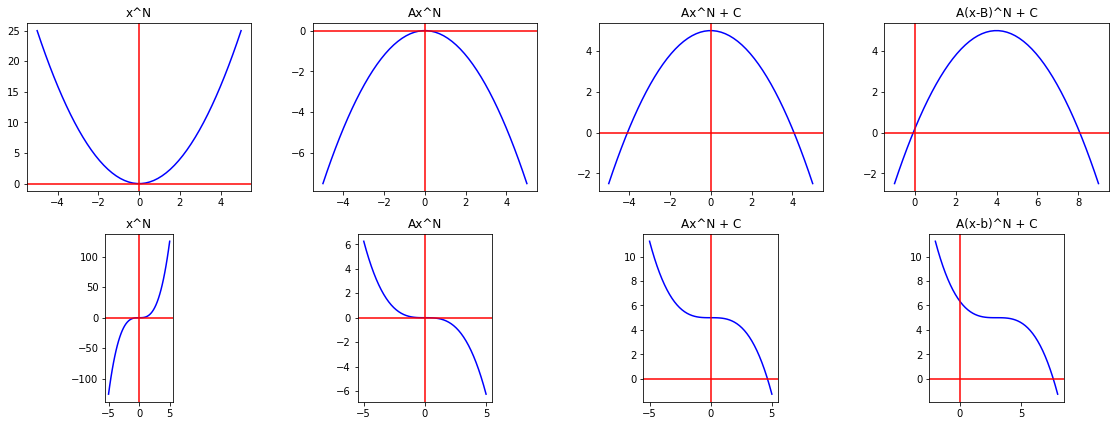

In [12]:
maize.shower_thought()

## Main problem: we don't know the angle formed by the tip of the leaf dangling.

- We can solve easily the first half: from base to top.
    - We know the angle formed by the base of the leaf with the stem
    
- We do not have an extra angle measure when it comes to the tip
    - We assume that the leaf dangles with the same angle as the one between the base and the stem.
    - We can correct that angle if the the resulting polynomial model is too steep (low $N$) or too flat (high $N$)

In [30]:
PlotData.iloc[305]

plot                             MIH119_2128
Pass                                      17
Range                                     15
Rep                                        2
New_Pedigree            PHW65_MoG_0125/PHT69
Old_Pedigree            PHW65_MoG_0125/PHT69
Old_Source                      WIPV17/31036
Shared                                     1
LPlant.L1.End.Angle                       59
LPlant.L1.End.Length                      61
LPlant.L1.Mid.Angle                       50
LPlant.L1.Mid.Length                      68
LPlant.L1.Stem.Angle                      29
Name: 377, dtype: object

In [31]:
idx = 305

deg = np.sort(degs[idx])
length = lengths[idx]
deg = 90 - deg
if deg[0] > 89:
    deg[0] = 89
print(deg)
print(length)

wblade, wparams = maize.poly_weight_blade_fit(deg, length, 100, dangle_correction=True)
ublade, uparams = maize.poly_weight_blade_fit(deg, length, 100, dangle_correction=False)

blade, params, _ = maize.poly_blade_fit(deg, length, 100)
dblade, dparams, _ = maize.poly_blade_fit(deg, length, 100, dangle_correction=False)

[61. 40. 31.]
[68. 61.]


/home/ejam/documents/synthetic_maize/code/amaizeing_utils.py:463: RuntimeWarning: divide by zero encountered in double_scalars
  A1 = (d-c)/np.power(b-a, np.floor(N))
/home/ejam/documents/synthetic_maize/code/amaizeing_utils.py:464: RuntimeWarning: divide by zero encountered in double_scalars
  A2 = (d-c)/np.power(b-a, np.ceil(N))
/home/ejam/documents/synthetic_maize/code/amaizeing_utils.py:662: RuntimeWarning: divide by zero encountered in double_scalars
  A = (d-c)/np.power(b-a, N)
/home/ejam/documents/synthetic_maize/code/amaizeing_utils.py:672: RuntimeWarning: invalid value encountered in multiply
  poly = A*np.power(np.abs(x-a), N) + c


	Model 0
Up::::	A = -1.61e-02	N = 2.15
Down::	B = -1.23e+01	M = 0.03
	Model 1
Up::::	A = -1.61e-02	N = 2.15
Down::	B = -1.23e+01	M = 0.30
	Model 2
Up::::	A = 8.90e-03	N = 2.15
Down::	B = -1.29e+01	M = 0.03
	Model 3
Up::::	A = 8.90e-03	N = 2.15
Down::	B = -inf	M = 5055780896.01
--------
a = 52.09	c = 43.71
b = 52.29	d = 31.42
-------


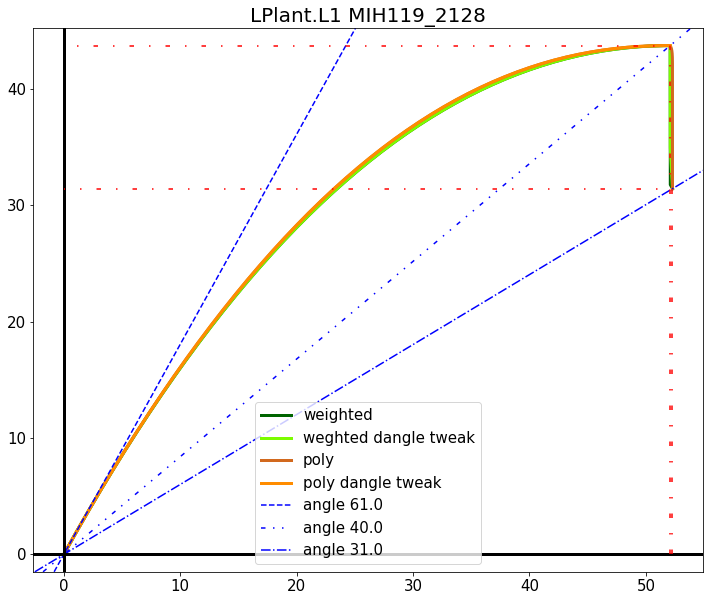

In [32]:
title = '.'.join(numbers.columns[0].split('.')[:2]) + ' ' + PlotData.iloc[idx,0]
maize.plot_poly_blade([ublade,wblade,dblade,blade], deg, 
                      [uparams,wparams,dparams,params], title=title, 
                      labels=['weighted','weghted dangle tweak','poly', 'poly dangle tweak'], 
                      verbose=True)

## 

## Compute the polynomial coefficients for the rest of leaves

In [17]:
resol = 100
Params= np.empty((len(degs), 8))
Blade = [None for i in range(len(degs))]
NormBlade = []
Extra = np.empty((len(degs), 2))

for idx in range(len(degs)):
    deg = np.sort(degs[idx])
    length = lengths[idx]
    deg = 90 - deg
    if deg[0] > 89:
        deg[0] = 89
    
    blade, params, down_curled = maize.poly_blade_fit(deg, length, resol)
    length_blade = np.sum(np.sqrt(np.sum(np.diff(blade, axis=0)**2, axis=1)))
    
    if down_curled:
        length_blade *= 1.75

    norm_blade = blade/length_blade
    
    Params[idx,:] = params
    Extra[idx, :] = length_blade, down_curled
    Blade[idx] = blade
    
    if not down_curled:
        NormBlade.append(norm_blade)

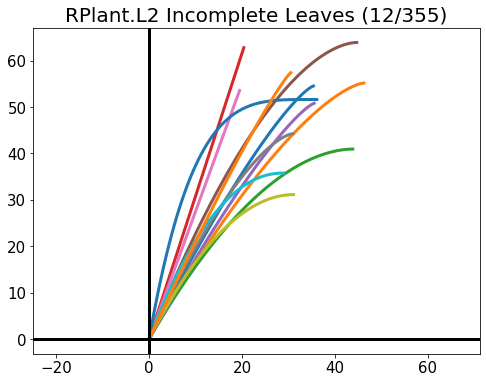

In [18]:
dst = '../model/'
plotname = '.'.join(numbers.columns[0].split('.')[:2])
curled = np.nonzero(Extra[:,1])[0]

plt.figure(figsize=(8,6))

for i in curled:
#for i in range(50,63):
    plt.plot(Blade[i][:,0], Blade[i][:,1], lw=3, label=i)

plt.axvline(x=0, c='k', lw=3)
plt.axhline(y=0, c='k', lw=3)
#plt.legend()
plt.title(plotname + ' Incomplete Leaves ({}/{})'.format(len(curled),len(Blade)),
          fontsize=20)
plt.tick_params(labelsize=15)
plt.axis('equal');

filename = dst + 'poly_model_' + plotname + '_incomplete_leaves.png'
plt.savefig(filename, dpi=150, format='png', bbox_inches='tight',
                    facecolor='white', transparent=False)

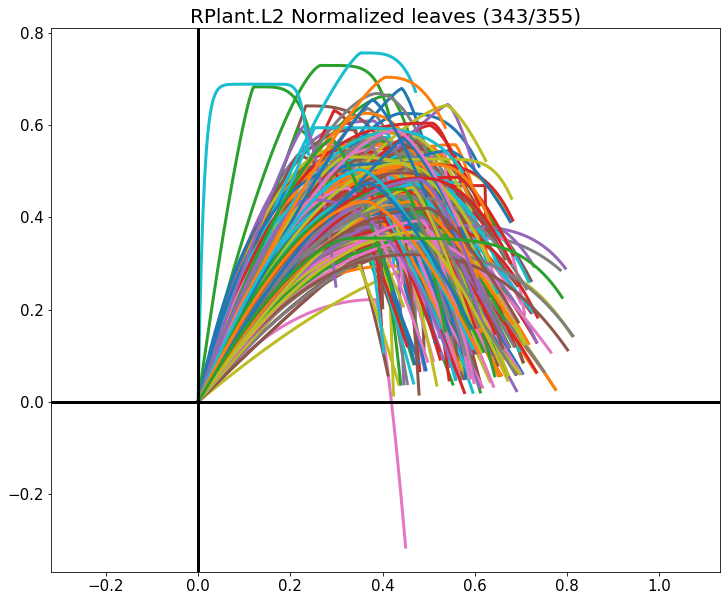

In [19]:
plt.figure(figsize=(12,10))

for i in range(len(NormBlade)):
#for i in range(50,63):
    plt.plot(NormBlade[i][:,0], NormBlade[i][:,1], lw=3)

plt.axvline(x=0, c='k', lw=3)
plt.axhline(y=0, c='k', lw=3)
plt.title(plotname + ' Normalized leaves ({}/{})'.format(len(NormBlade),len(Blade)), fontsize=20)
plt.tick_params(labelsize=15)
plt.axis('equal');

filename = dst + 'poly_model_' + plotname + '_normalized.png'
plt.savefig(filename, dpi=150, format='png', bbox_inches='tight',
                    facecolor='white', transparent=False)

## Save the coefficients in a CSV

In [91]:
param_df = pd.DataFrame(np.column_stack((Params,Extra)), 
                        index=PlotData.index, 
                        columns=['A1','N1','A2','N2','a','b','c','d','length','curled'])
df = pd.concat([PlotData, param_df], axis=1, join='inner')
df.to_csv(dst + plotname + '_poly_model.csv', index=True)
df

,plot,Pass,Range,Rep,New_Pedigree,Old_Pedigree,Old_Source,Shared,RPlant.L2.End.Angle,RPlant.L2.End.Length,...,A1,N1,A2,N2,a,b,c,d,length,curled
1,MIH119_1002,4,2,1,2369/LH123HT,2369/LH123HT,NaN,1.0,75,43.0,...,0.000187,3.480194,-1.219709e+00,1.369629,32.735921,41.534811,35.104978,11.129219,79.220553,0.0
2,MIH119_1003,5,2,1,B37/H95,B73/PHN82,NaN,NaN,43,46.0,...,0.578393,1.274534,0.000000e+00,0.000000,35.401537,31.371925,54.513587,33.642270,114.470415,1.0
3,MIH119_1004,6,2,1,B37/H95,B14A/H95,NaN,NaN,85,69.0,...,0.070086,1.710193,-4.182546e-02,1.859051,36.414096,68.737434,32.787400,6.013746,93.843065,0.0
5,MIH119_1006,8,2,1,B37/H95,B37/H95,NaN,1.0,40,72.0,...,0.209486,1.453363,0.000000e+00,0.000000,46.280708,46.280708,55.155200,55.155200,127.988660,1.0
6,MIH119_1007,9,2,1,B37/H95,B73/MO17,NaN,NaN,55,50.0,...,0.004869,2.613210,-1.385162e+00,1.351549,33.841010,40.957602,48.329971,28.678822,84.592126,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,MIH119_2242,15,19,2,PHW65_MoG_0591/PHT69,PHW65_MoG_0591/PHT69,WIPV17/31189,1.0,86,54.0,...,0.038592,1.827946,-5.332143e-01,1.397534,37.824516,53.868459,29.551751,3.766850,80.271587,0.0
493,MIH119_2244,13,19,2,PHW65_MoG_0620/PHT69,PHW65_MoG_0620/PHT69,WIPV17/31191,1.0,70,44.0,...,0.170406,1.649586,-3.347727e-01,1.557441,26.384516,41.346475,37.680994,15.048886,74.877552,0.0
494,MIH119_2245,12,19,2,PHW65_MoG_0622/PHT69,PHW65_MoG_0622/PHT69,WIPV17/30593,1.0,75,51.0,...,0.381486,1.353226,-4.623389e-01,1.384210,30.783074,49.262217,39.400538,13.199771,82.960360,0.0
497,MIH119_2248,9,19,2,PHW65_MoG_0660/PHT69,PHW65_MoG_0660/PHT69,WIPV17/31197,1.0,80,50.0,...,0.103894,1.720409,-2.877370e-01,1.518845,29.568230,49.240388,35.238044,8.682409,81.096014,0.0


## Make individual blade model plots

In [37]:
dst = '../model/rpl1/'

importlib.reload(maize)
for idx in range(len(degs)):
    title = '.'.join(numbers.columns[0].split('.')[:2]) + ' ' + PlotData.iloc[idx,0]
    deg = np.sort(degs[idx])
    deg = 90 - deg
    if deg[0] > 89:
        deg[0] = 89
    
    maize.plot_poly_blade([Blade[idx]], deg, [Params[idx]], 
                          title=title, labels=['Polymodel'], dpi=40, dst=dst,
                         writefig=True)